In [36]:
from sklearn.datasets import load_boston
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.stats
import matplotlib.pyplot as plt

In [144]:
from torchviz import make_dot

In [128]:
df = pd.read_csv('airfoilselfnoise.csv')

In [129]:
df.head()

,f,alpha,c,U_infinity,delta,SSPL
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [130]:
data = df
data = data.apply(
    lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
)

In [131]:
X = data.drop('SSPL', axis=1).to_numpy()
Y = data['SSPL'].to_numpy()

In [132]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1052, 5)
(451, 5)
(1052,)
(451,)


In [133]:
n_train = X_train.shape[0]
X_train = torch.tensor(X_train, dtype=torch.float64)
X_test = torch.tensor(X_test, dtype=torch.float64)
Y_train = torch.tensor(Y_train, dtype=torch.float64).view(-1, 1)
Y_test = torch.tensor(Y_test, dtype=torch.float64).view(-1, 1)

In [134]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(datasets, batch_size=32, shuffle=False)

In [135]:
dataset_test = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

In [136]:
class Model(nn.Module):
    def __init__(self, n_inputs):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(n_inputs, 5, dtype=torch.float64)
        self.linear2 = nn.Linear(5, 1, dtype=torch.float64)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        
        return x

In [137]:
def validate_traditional_model(model):
    loss = 0.0
    for i, (data, target) in enumerate(test_loader):
        output = model(data)
        loss += F.mse_loss(output, target)
    return loss.item() / len(test_loader.dataset)

In [138]:
def validate_beta_model(model):
    loss = 0.0
    for i, (data, target) in enumerate(test_loader):
        target = torch.squeeze(target)
        alpha, beta = model(data)
        output = alpha / (alpha + beta)
        loss += F.mse_loss(output, target)
    return loss.item() / len(test_loader.dataset)

In [139]:
criterion = torch.nn.MSELoss()

In [140]:
model = Model(X_train.shape[1])

In [141]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [142]:
model_nll_loss = []
model_mse_loss = []
model_mse_val_loss = []

num_epochs = 100
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_loader):
        output = model(x)
        # print(y, output)
        loss = criterion(output, y)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i == 0:
            model_nll_loss.append(loss.item())
            model_mse_loss.append(F.mse_loss(output, y).item())
            print("epoch {} loss: {:.4f}".format(epoch + 1, loss.item()))
            print("MSE: ", F.mse_loss(output, y).item())
            model_mse_val_loss.append(validate_traditional_model(model))
            
writer.flush()

epoch 1 loss: 1.1758
MSE:  1.175752347530212
epoch 2 loss: 0.8684
MSE:  0.8684487273869166
epoch 3 loss: 0.6493
MSE:  0.6493307624701239
epoch 4 loss: 0.4855
MSE:  0.48550674708085273
epoch 5 loss: 0.3604
MSE:  0.36038170624086097
epoch 6 loss: 0.2659
MSE:  0.26589316191439766
epoch 7 loss: 0.1960
MSE:  0.19604598565087136
epoch 8 loss: 0.1465
MSE:  0.1465340961702083
epoch 9 loss: 0.1133
MSE:  0.1132960581199
epoch 10 loss: 0.0921
MSE:  0.09211644233188773
epoch 11 loss: 0.0794
MSE:  0.07942647167757443
epoch 12 loss: 0.0721
MSE:  0.07213206440780792
epoch 13 loss: 0.0679
MSE:  0.06793978380688726
epoch 14 loss: 0.0654
MSE:  0.06535823772929503
epoch 15 loss: 0.0635
MSE:  0.06352149148959677
epoch 16 loss: 0.0620
MSE:  0.061982424073319144
epoch 17 loss: 0.0605
MSE:  0.0605304201963552
epoch 18 loss: 0.0591
MSE:  0.05909382948418461
epoch 19 loss: 0.0577
MSE:  0.05765002713889001
epoch 20 loss: 0.0562
MSE:  0.056198086099051935
epoch 21 loss: 0.0547
MSE:  0.05474437332070352
epoch 22 

In [147]:
example_id = 0

pred = model(X_test[example_id])
target = Y_test[example_id]

print(f"pred:{pred.item()} target:{target.item()}")
print("NLL Loss: ", criterion(pred, target).item())
print("MSE Loss: ", F.mse_loss(pred, target).item())


pred:0.5478847317826436 target:0.5760895577950915
NLL Loss:  0.0007955122103924573
MSE Loss:  0.0007955122103924573


In [148]:
print(model)

Model(
  (linear1): Linear(in_features=5, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)


In [107]:
def el(x):
    return torch.nn.functional.elu(x) + 1

In [108]:
def mean_squared_error(alpha, beta, target):
    # print(alpha.shape, beta.shape, target.shape)
    output = alpha / (alpha + beta)
    return F.mse_loss(output, target).item()

In [109]:
class ModelBeta(nn.Module):
    def __init__(self, n_inputs):
        super(ModelBeta, self).__init__()
        self.linear1 = nn.Linear(n_inputs, 5, dtype=torch.float64)
        self.linear2 = nn.Linear(5, 2, dtype=torch.float64)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = el(self.linear2(x))
        
        return x[:, 0], x[:, 1]

In [110]:
EPS = torch.finfo(torch.float64).eps

In [111]:
def criterion_beta(z, alpha, beta):
    z = torch.clamp(z, min=EPS, max=1-EPS)
    return  -((alpha - 1) * torch.log(z) + \
            (beta - 1) * torch.log(1 - z) + \
            torch.lgamma(alpha + beta) - \
            torch.lgamma(alpha) - \
            torch.lgamma(beta)).mean()

In [112]:
model_beta = ModelBeta(X_train.shape[1])

In [113]:
optimizer = torch.optim.Adam(model_beta.parameters(), lr=0.001)

In [114]:
model_beta_nll_loss = []
model_beta_mse_loss = []
model_beta_val_mse_loss = []

num_epochs = 100
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_loader):
        y = torch.squeeze(y)
        # print(y.shape)
        alpha, beta = model_beta(x)
        # print(y, alpha, beta)
        loss = criterion_beta(y, alpha, beta)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i == 0:
            model_beta_nll_loss.append(loss.item())
            model_beta_mse_loss.append(mean_squared_error(alpha, beta, y))
            print("epoch {} loss: {:.4f}".format(epoch + 1, loss.item()))
            print("MSE:", mean_squared_error(alpha, beta, y))
            model_beta_val_mse_loss.append(validate_beta_model(model_beta))

epoch 1 loss: 0.2465
MSE: 0.07102926061428612
epoch 2 loss: 0.1638
MSE: 0.05962392523570816
epoch 3 loss: 0.0914
MSE: 0.04946418681584365
epoch 4 loss: 0.0267
MSE: 0.040746050722496915
epoch 5 loss: -0.0128
MSE: 0.03631421759356997
epoch 6 loss: -0.0377
MSE: 0.034394082419035986
epoch 7 loss: -0.0564
MSE: 0.0335046307483364
epoch 8 loss: -0.0725
MSE: 0.03292922614978992
epoch 9 loss: -0.0873
MSE: 0.032464868453534315
epoch 10 loss: -0.1011
MSE: 0.03205997156577349
epoch 11 loss: -0.1139
MSE: 0.031697357332950295
epoch 12 loss: -0.1259
MSE: 0.03136735076799436
epoch 13 loss: -0.1371
MSE: 0.031063349649406113
epoch 14 loss: -0.1477
MSE: 0.030779989848780994
epoch 15 loss: -0.1576
MSE: 0.030512045920012706
epoch 16 loss: -0.1670
MSE: 0.030256521748704177
epoch 17 loss: -0.1758
MSE: 0.03001019662681292
epoch 18 loss: -0.1842
MSE: 0.029770206731123613
epoch 19 loss: -0.1921
MSE: 0.029534217999825765
epoch 20 loss: -0.1996
MSE: 0.029300117822751902
epoch 21 loss: -0.2068
MSE: 0.0290660411205

In [115]:
example_id = 0
test_data = X_test[example_id]
test_target = Y_test[example_id]
a, b = model_beta(test_data.unsqueeze(0))

print("alpha:", a.item(), "| beta:", b.item())
print("Target:", test_target.item(), "| Predicted(using mean): ", (a / (a+b)).item())
print("NLL Loss:", criterion_beta(test_target,a , b).item())
print("MSE Loss:", mean_squared_error(a, b, test_target))

alpha: 4.324879220452097 | beta: 3.5057128875375314
Target: 0.5760895577950915 | Predicted(using mean):  0.5523055167232349
NLL Loss: -0.7798225126097162
MSE Loss: 0.0005656806097077621


In [149]:
print(model_beta)

ModelBeta(
  (linear1): Linear(in_features=5, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=2, bias=True)
)


/Users/atulramkrishnan/miniforge3/envs/pytorch_nightly/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


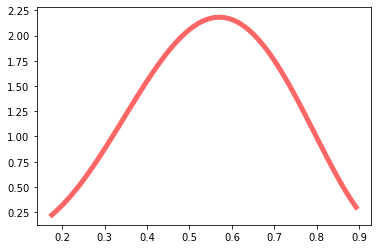

In [116]:
a = a.detach().numpy()
b = b.detach().numpy()
x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)

plt.plot(x, scipy.stats.beta.pdf(x, a, b),
       'r-', lw=5, alpha=0.6, label='beta pdf')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


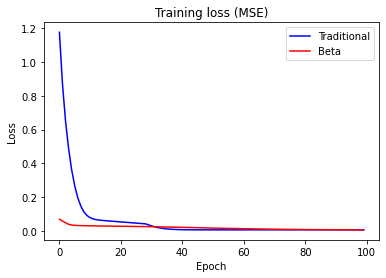

In [152]:
plt.plot(model_mse_loss, 'b', label='Traditional')
plt.plot(model_beta_mse_loss, 'r', label='Beta')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss (MSE)')
plt.legend()
plt.savefig('Airfoil training MSE loss.eps')

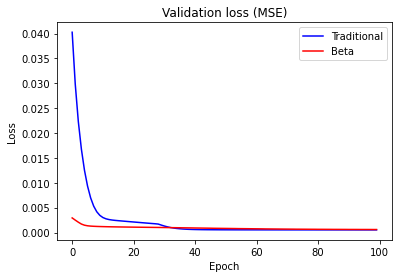

In [151]:
plt.plot(model_mse_val_loss, 'b', label='Traditional')
plt.plot(model_beta_val_mse_loss, 'r', label='Beta')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation loss (MSE)')
plt.legend()
plt.savefig('Airfoil validation MSE loss.png')